# Install and Import Dependencies

In [ ]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


# Import Library

In [ ]:
from datasets import load_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import warnings
import os
import nltk

from IPython.display import Audio
from transformers import pipeline
from datasets import load_dataset
from time import time
from google.colab import drive

warnings.filterwarnings('ignore')
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
curr_path = os.getcwd()
print(curr_path)

/content


In [ ]:
!nvidia-smi

Fri May  3 07:03:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Dataset

In [ ]:
minds_14 = load_dataset("PolyAI/minds14", "en-US")
# to download all data for multi-lingual fine-tuning uncomment following line

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# see structure
print(minds_14)

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 563
    })
})


# EDA

In [ ]:
# konversi dataset ke dataframe
df = pd.DataFrame(minds_14["train"])

# menampilkan DataFrame
df.head()

,path,audio,transcription,english_transcription,intent_class,lang_id
0,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,I would like to set up a joint account with my...,I would like to set up a joint account with my...,11,4
1,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,Henry County set up a joint account with my wi...,Henry County set up a joint account with my wi...,11,4
2,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,hi I'd like to set up a joint account with my ...,hi I'd like to set up a joint account with my ...,11,4
3,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,how do I start a joint account,how do I start a joint account,11,4
4,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,can you help me set up a joint bank account,can you help me set up a joint bank account,11,4


## Intent Class Distribution

In [ ]:
intent_class_interpret = list()
for idx in df.index:
  intent_class = minds_14["train"][idx]["intent_class"]
  interpret = minds_14['train'].features['intent_class'].names[intent_class]
  intent_class_interpret.append(interpret)

df['intent_class_interpret'] = intent_class_interpret

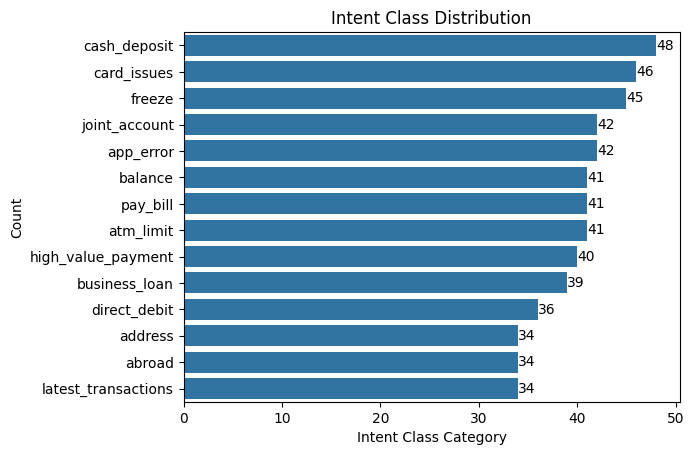

In [ ]:
# Group the data by the Category and sort by the count
sorted_counts = df['intent_class_interpret'].value_counts().sort_values(ascending=False)
sorted_categories = sorted_counts.index

# Create a count plot using Seaborn's countplot function
ax = sns.countplot(y='intent_class_interpret', data=df, order=sorted_categories)

# Add data labels on top of each bar
for p in ax.patches:
    count = int(p.get_width())  # Get the count for each bar
    ax.annotate(f'{count}',  # The text to display (count)
                (count, p.get_y() + p.get_height() / 2),  # Position the label
                ha='left',  # Horizontal alignment
                va='center',  # Vertical alignment
                color='black')  # Text color

# Customize your plot (optional)
plt.title('Intent Class Distribution')
plt.xlabel('Intent Class Category')
plt.ylabel('Count')


# Show the plot
plt.show()

## File Format Check

In [ ]:
df['file_format'] = df['path'].str[-3:]

df.file_format.value_counts()

file_format
wav    563
Name: count, dtype: int64

## Sampling Rate Check

In [ ]:
sr_dist = list()
for i in df.audio:
  sr_dist.append(i['sampling_rate'])

In [ ]:
df['sampling_rate_ori'] = sr_dist
df.sampling_rate_ori.value_counts()

sampling_rate_ori
8000    563
Name: count, dtype: int64

## Waveforms

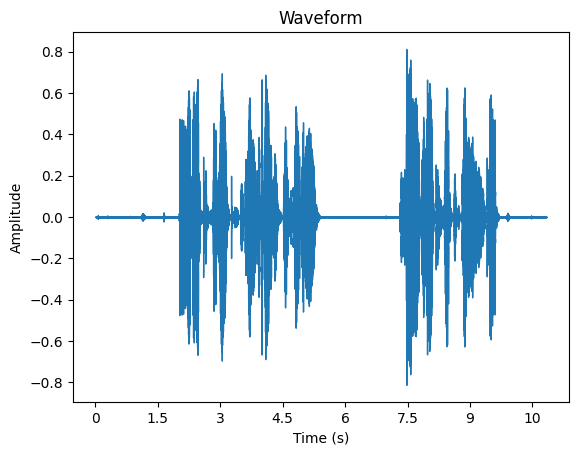

In [ ]:
# Load audio file
audio_path = df.path[0]
audio, sr = librosa.load(audio_path)

# Plot the waveform
plt.figure()
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## Spectogram

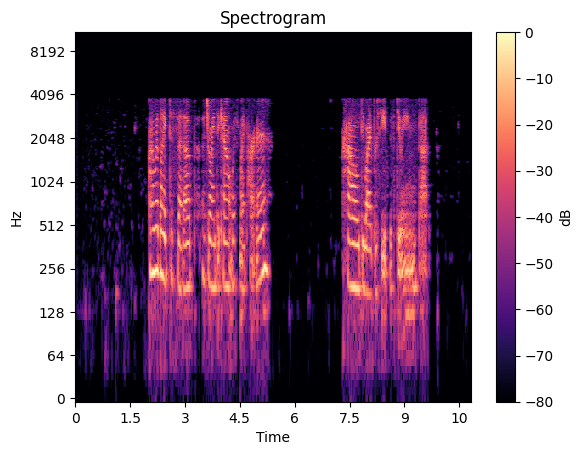

In [ ]:
# Load audio file
audio_path = df.path[0]
audio, sr = librosa.load(audio_path)

# Compute the spectrogram using STFT
D = librosa.stft(audio)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot the spectrogram
plt.figure()
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.title('Spectrogram')
plt.colorbar(label='dB')
plt.show()

## Audio

In [ ]:
audio_path = df.path[0]

Audio(audio_path)

## Duration

In [ ]:
# Function to calculate duration of audio files
def calculate_duration(audio_path):
    audio, sr = librosa.load(audio_path)
    duration = len(audio) / sr
    return duration

# Apply the function to calculate duration for each audio file path in the DataFrame
df['duration'] = df['path'].apply(calculate_duration)

In [ ]:
# Group the DataFrame by class and calculate the average duration per class
avg_duration_per_class = df.groupby('intent_class_interpret')['duration'].mean()

# Display the results
print(avg_duration_per_class)

intent_class_interpret
abroad                 13.093235
address                 5.457615
app_error              11.388073
atm_limit              10.063333
balance                 5.413221
business_loan           7.418265
card_issues             9.845279
cash_deposit            7.498313
direct_debit            6.419835
freeze                  7.732939
high_value_payment     12.031932
joint_account           7.688373
latest_transactions     9.115956
pay_bill                7.077515
Name: duration, dtype: float64


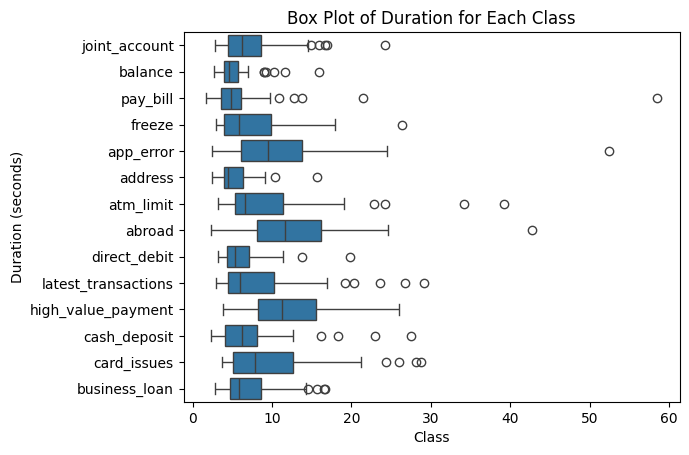

In [ ]:
# Create a box plot of duration for each class using Seaborn's boxplot function
sns.boxplot(y='intent_class_interpret', x='duration', data=df)

# Customize your plot (optional)
plt.title('Box Plot of Duration for Each Class')
plt.xlabel('Class')
plt.ylabel('Duration (seconds)')

# Show the plot
plt.show()

## MFCC

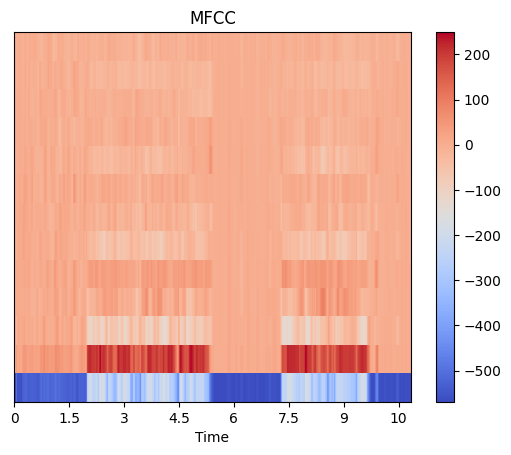

In [ ]:
# Load audio file
audio_path = df.path[0]
audio, sr = librosa.load(audio_path)

# Compute MFCCs
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

# Plot the MFCCs
plt.figure()
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.title('MFCC')
plt.colorbar()
plt.show()